---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:`
* This script will download all PDF files from an AWS S3 bucket, maintaining the directory structure, and store them in a DataFrame.
* Ensure you have the necessary AWS credentials and configurations set in a .env file.
* The script uses boto3 to interact with S3, pandas to handle the data, and re for string manipulation.
* The script first downloads all PDF files, then filters these files to obtain those with the most recent and oldest years per company.
* Finally, it extracts the content of the filtered PDFs using the LlamaParse library.
* The extracted content is stored in a new DataFrame, which includes the PDF file names and their corresponding text content.


In [1]:
# Importing the necessary libraries
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.plots import(
  analyze_text,
  analyze_sentiment,
  generate_word_cloud,
  plot_common_words,
  display_ngrams_with_plot_side_by_side,
)

[nltk_data] Downloading package punkt to /home/yohana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from src import data_utils

# Call the function to download the PDFs
filtered_pdfs_df = data_utils.download_pdfs_and_convert_to_text()

Started parsing the file under job_id cac11eca-aeda-44b4-a291-9bfb2e38e50a
Started parsing the file under job_id cac11eca-ebeb-470b-aca1-b5acb8c7b6b2



## 2. Normalize the data

**Normalizing text is crucial for preparing data for further analysis, ensuring the text is consistent and easy to process by removing noise and standardizing the format.**

- **Text Cleaning (`clean_text`):** Convert text to lowercase, remove unwanted characters such as punctuation, URLs, HTML tags, and digits.
- **Expand Contractions (`expand_contractions`):** Replace contractions (e.g., "can't" to "cannot") using a predefined dictionary of contractions.
- **Lemmatize Text (`lemmatize_text`):** Tokenize the text and apply lemmatization to convert words to their base form (e.g., "running" to "run").
- **Remove Stopwords (`remove_stopwords`):** Tokenize the text and remove common stop words that do not contribute to the meaning (e.g., "and", "the").
- **Normalize Corpus (`normalize_corpus`):** Combine text chunks into a single string if needed, apply text cleaning, contraction expansion, lemmatization, and stop word removal in sequence, save the cleaned and processed text to a `.txt` file with a specified prefix, and return the normalized text and the output file name.


In [3]:
from src import text_normalizer

# Text cleanup and normalization
cleaned_text = text_normalizer.normalize_corpus(filtered_pdfs_df)

[nltk_data] Downloading package punkt to /home/yohana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yohana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yohana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
cleaned_text

'2019 annual report | |seld|nir2o2c09| | | -- -| -- -| -- -| -- -| | |cheddar|shaap| | | |cheese|vus saved| | |popcorthe factor|ftsa uhoco cky dpcor| | | | | |rowth|muse lpi munch| |driving g|kr pofcornr e popcorn| | | | |d|bu momgnidil| | | |mutne| | | driving growth building momentum vision inspire human expression connection celebration mission deliver smile 1-800-flowerscom inc leading provider gift designed inspire human expression connection celebration company celebration ecosystem feature all-star family brand including 1-800-flowerscom 1-800-basketscom cheryls cooky harry david shari berry fruitbouquetscom moose munch popcorn factory wolfermans bakerysm personalization universe simply chocolate goodsey also offer top-quality steak chop stock yard celebration passport loyalty program provides member free standard shipping service charge across portfolio brand 1-800-flowerscom inc strives deepen relationship customer company also operates bloomnet international floral wire servi

In [5]:
# Call the analyze_text function
X, num_words, vocab_sample = analyze_text(cleaned_text)

print("Number of words in the vocabulary:", num_words)
print("Words in the vocabulary:", vocab_sample)

Number of words in the vocabulary: 4101
Words in the vocabulary: ['00' '01' '012620270000144327000021065' '01271990012809005436' '012720'
 '012818' '018' '02' '020' '022320112941153011294119333']


In [6]:
sentiment = analyze_sentiment(cleaned_text)
print(f"Sentiment of the text: Polarity={sentiment.polarity}, Subjectivity={sentiment.subjectivity}")

Sentiment of the text: Polarity=0.08202604561059859, Subjectivity=0.37003517703622313


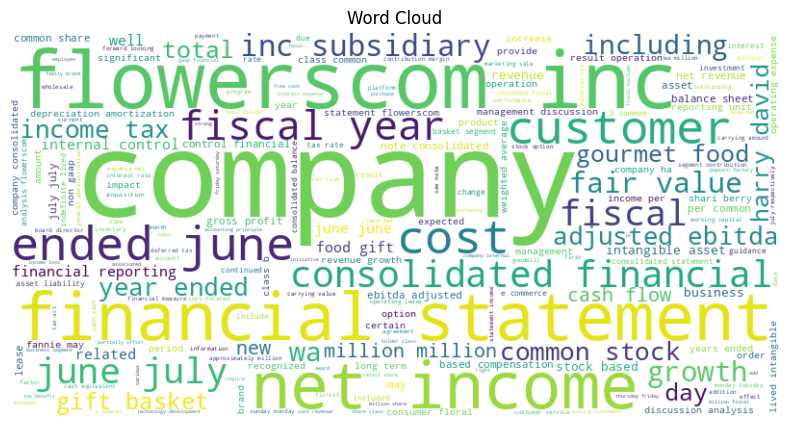

In [7]:
generate_word_cloud(cleaned_text)

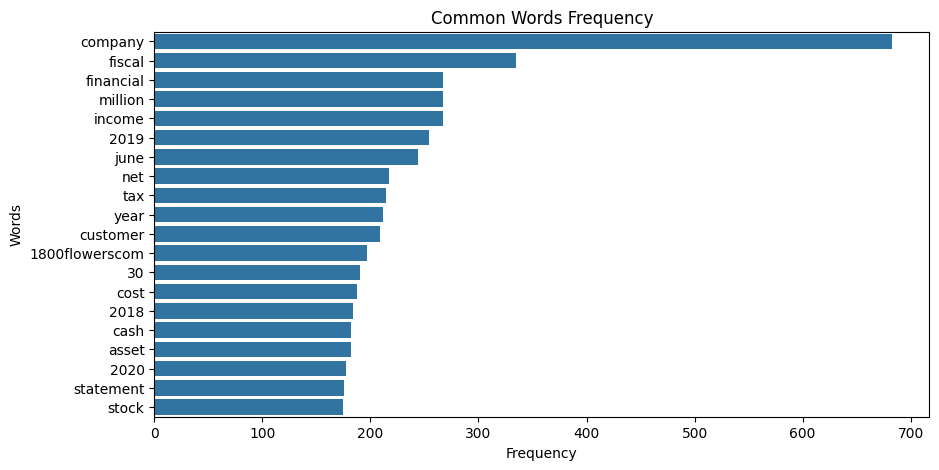

In [8]:
plot_common_words(cleaned_text)

In [7]:
print("Top 10 Bigrams:")
display_ngrams_with_plot_side_by_side(cleaned_text, n=2, top_n=10)


,word_1,ngram_size,word_2
0,2019,1,NaN
1,annual,1,NaN
2,report,1,NaN
3,seldnir2o2c09,1,NaN
4,cheddarshaapcheese,1,NaN
...,...,...,...
63706,place,2,ny
63707,ny,2,11514
63708,11514,2,1800flowerscom
63709,1800flowerscom,2,516


---
## 3. Feature Engineering

In this stage, we have split the texts into fragments and vectorized them so that the machine learning models can understand them. We used the `CharacterTextSplitter` class from LangChain to divide the long texts into more manageable fragments, ensuring that each fragment retains enough context.

After splitting the texts, we store the fragments in a new column of the DataFrame. Then, we use OpenAI embeddings to convert these text fragments into numerical vectors. Embeddings are numerical representations that capture the semantics and context of the texts.

Finally, we store these vectors in a `VectorStore` using FAISS, a library for searching and storing large amounts of vectors. This will allow us to search and retrieve similar text fragments quickly and efficiently.


In [ ]:
from src import text_processing

# Split the text into fragments
text_chunks = text_processing.get_text_chunks(cleaned_text)

# Create the VectorStore using the text fragments
vectorstore = text_processing.get_vectorstore(text_chunks)